In [68]:
using DifferentialEquations
using Distributions
using Plots
using LinearAlgebra
using Random
Random.seed!(4)
include("UKF_1Measurement.jl");

Give functions and parameters of problems set up for ODE processes. 
1. The real process must be named "RealProcess!"
2. The model process must be named "ModelSystem!"
3. The names of the parameters must be included as a mutable struct.

In [69]:
function RealProcess!(dx, x, p, t)
    u1, u2, c1, Sp, g, A, c2, c3, alpha, r = p.u1, p.u2, p.c1, p.Sp, p.g, p.A, p.c2, p.c3, p.alpha, p.r
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    qf = 0
    dx[1] = (-c1 * Sp * sign(x1 - x3) * sqrt(2 * g * abs(x1 - x3)) + u1)/(A)
    dx[2] = (-c3 * Sp * sign(x2 - x3) * sqrt(2 * g * abs(x2 - x3)) - c2 * Sp * sqrt(2 * g * x2) - qf + u2)/(A)
    dx[3] = (c1 * Sp * sign(x1 - x3) * sqrt(2 * g * abs(x1 - x3)) - c3 * Sp * sign(x3 - x2) * sqrt(2 * g * abs(x3 - x2)))/(A)
end

mutable struct Params
    u1 #m^3/s
    u2 #m^3/s
    c1 #Normal(1.0, 0.0025)
    Sp #m^2
    g #m/s^2
    A #m^2
    c2 #Normal(0.8, 0.0025)
    c3 #Normal(1.0, 0.0025)
    alpha #Normal(0.6, 4e-4)
    r # Normal(0.002, 10e-6)
end

function ModelSystem!(dx, x, p, t)
    #u1, u2, c1, Sp, g, A, c2, c3, alpha, r = p.u1*1.1, p.u2*0.9, p.c1*0.8, p.Sp, p.g, p.A, p.c2*0.9, p.c3*1.2, p.alpha, p.r*1.2
    u1, u2, c1, Sp, g, A, c2, c3, alpha, r = p.u1, p.u2, p.c1, p.Sp, p.g, p.A, p.c2, p.c3, p.alpha, p.r
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    qf = 0
    dx[1] = (-c1 * Sp * sign(x1 - x3) * sqrt(2 * g * abs(x1 - x3)) + u1)/(A)
    dx[2] = (-c3 * Sp * sign(x2 - x3) * sqrt(2 * g * abs(x2 - x3)) - c2 * Sp * sqrt(2 * g * x2) - qf + u2)/(A)
    dx[3] = (c1 * Sp * sign(x1 - x3) * sqrt(2 * g * abs(x1 - x3)) - c3 * Sp * sign(x3 - x2) * sqrt(2 * g * abs(x3 - x2)))/(A)
end

ModelSystem! (generic function with 1 method)

1. Set up the time frame of the process

In [70]:
estimationlength = 20           #specifiy the length of the state estimation period by the number of state estimates obtained.
N_meas = 10                     #s, specify the time difference between samples
tstart = 0
tend = tstart + estimationlength * N_meas
timesteps = tstart:N_meas:(estimationlength*N_meas);

2. Declare process parameters and initial conditions of the "real" system

In [71]:
normalparams = Params(6e-5, 6e-5, 1, 5e-5, 9.81, 0.0154, 0.8, 1.0, 0.6, 0.002)
x0 = [0.7, 0.3, 0.4];

3. Set up and solve ODE Problem of "real" system over the time spam specified in 1

In [72]:
prob = ODEProblem(RealProcess!, x0, (tstart, tend), normalparams)
ODEsol = solve(prob, Tsit5(), saveat = timesteps)
ODEsol2 = solve(prob, Tsit5());

4. Specify initial conditions of the Kalman filter and which state variables are measured.

In [73]:
xhat_0 = [0.5, 0.5, 0.5]        #initial state estimate supplied to Kalman Filter
nx = length(xhat_0)             #number of states
ny = 1                          #number of measurements
P0 = 0.0001*I(nx)               #initial covariance matrix
Q = 0.001*I(nx)                 #process noise covariance matrix

#Measured states
measured_state = 3              #measured state

vk_std = 0.02                   #standard deviation of measurement noise
R = [vk_std ^2];                #measurment noise variance

5. Generate measurements.

In [74]:
y = GenerateMeasurements(ODEsol, estimationlength, ny, xhat_0, vk_std, measured_state); #GenerateMeasurments(ODEsol, estimationlength, ny, xhat_0, vk_std, measured_variable)

Run the Kalman filter for the generated measurements:

In [75]:
(xhatarray, PArray) = RunFilter(estimationlength, N_meas, xhat_0, P0, nx, ny, R, Q, y, normalparams);


Plot results:

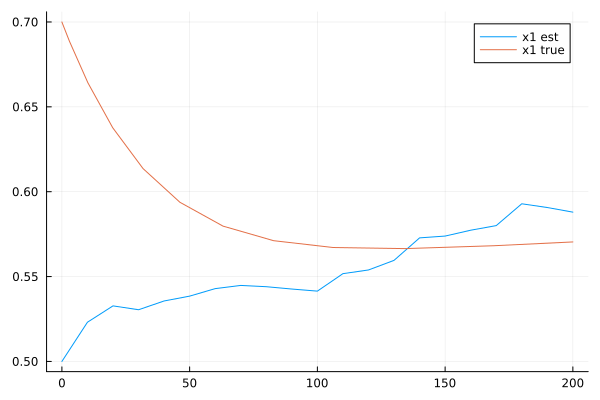

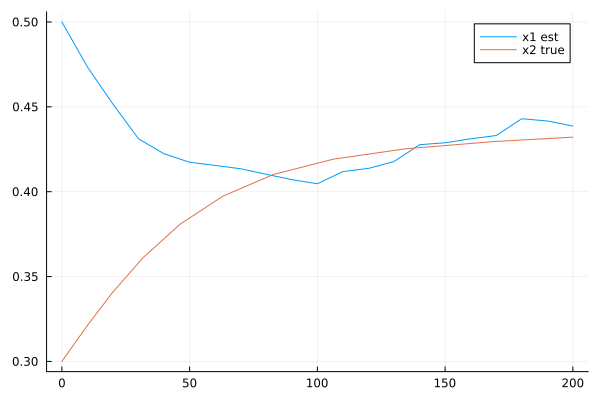

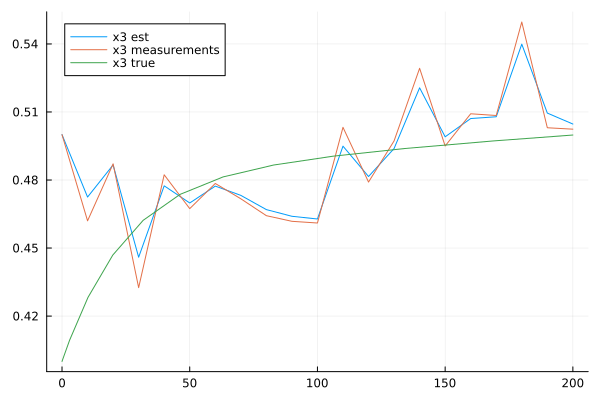

In [76]:
x1_stateestimates = [x[1] for x in xhatarray]
x2_stateestimates = [x[2] for x in xhatarray]
x3_stateestimates = [x[3] for x in xhatarray]

x1_truestate = [x[1] for x in ODEsol2.u]
x2_truestate = [x[2] for x in ODEsol2.u]
x3_truestate = [x[3] for x in ODEsol2.u]

y_measurements3 = vec(y)

plot(timesteps, x1_stateestimates, lab = "x1 est")
display(plot!(ODEsol2.t, x1_truestate, lab = "x1 true"))

plot(timesteps, x2_stateestimates, lab = "x1 est")
display(plot!(ODEsol2.t, x2_truestate, lab = "x2 true"))

plot(timesteps, x3_stateestimates, lab = "x3 est")
plot!(timesteps, y_measurements3, lab = "x3 measurements")
display(plot!(ODEsol2.t, x3_truestate, lab = "x3 true"))